In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import warnings
import requests
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Function to connect and query Wikimedia Cloud database
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    conn = pymysql.connect(
        host=wiki_name + '.analytics.db.svc.wikimedia.cloud',
        read_default_file=cnf_path,
        database=wiki_name + '_p'
    )
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [4]:
wikis = ['hiwiki', 'mlwiki','tewiki']


<h3>Average size of an edit by edit count bucket</h3>

In [5]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/avg_size_of_edit.sql"
query1 = requests.get(query_url).text

In [6]:
def get_data(wikis, query):
    all_data = []
    for wiki in wikis:
        result = connect_and_query(wiki, query)
        df = pd.DataFrame(result, columns=['edit_count_bucket', 'edit_size'])
        df['wiki'] = wiki
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

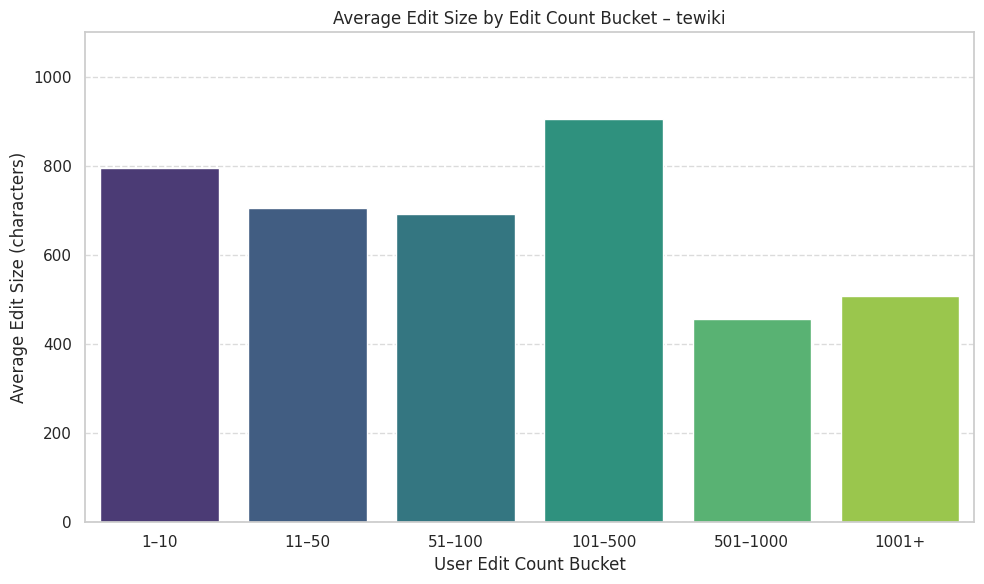

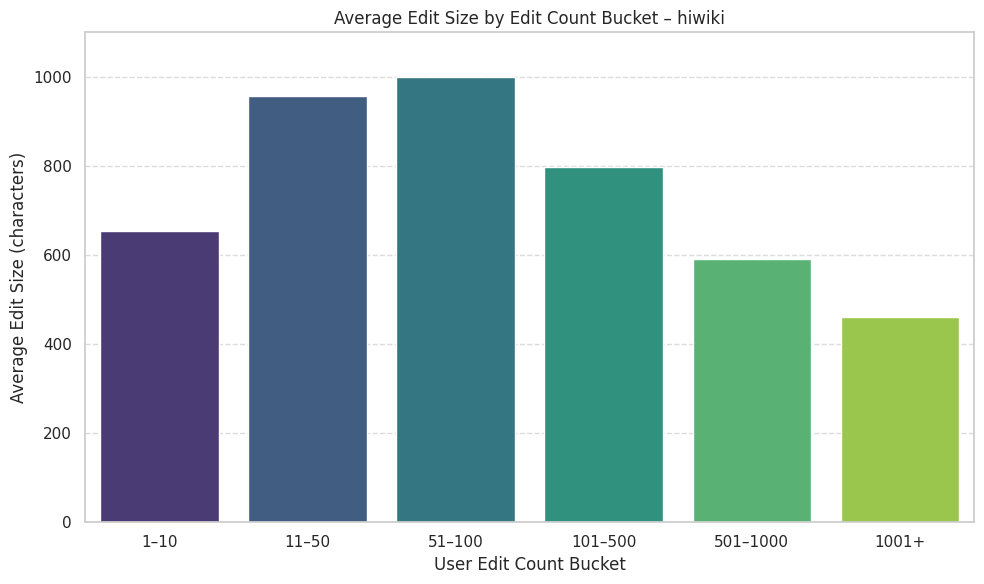

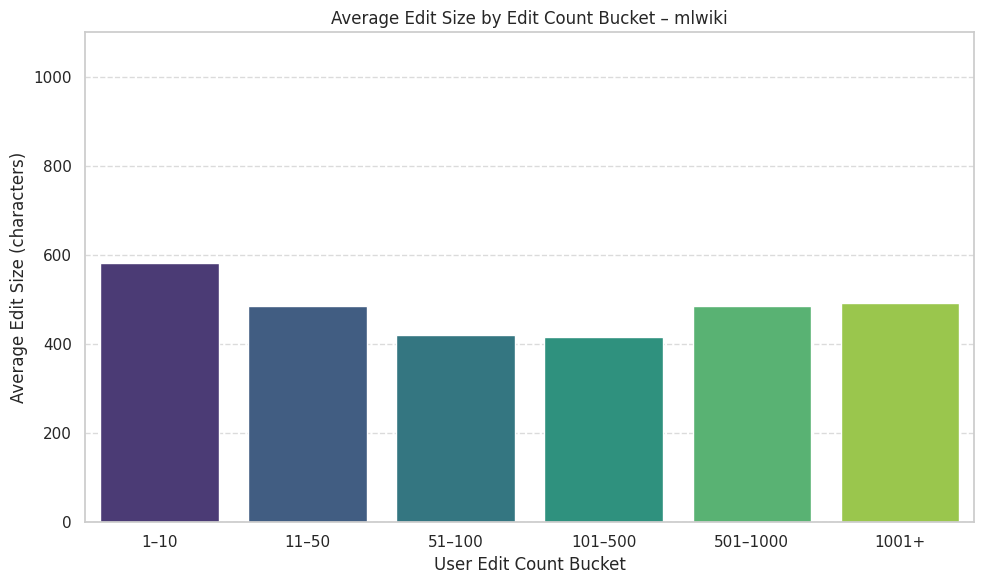

In [7]:
# Run your query and get data
edit_data = get_data(wikis, query1)

#  desired order of edit count buckets
bucket_order = ['1–10', '11–50', '51–100', '101–500', '501–1000', '1001+']


edit_data['edit_count_bucket'] = pd.Categorical(
    edit_data['edit_count_bucket'],
    categories=bucket_order,
    ordered=True
)

# Sort by bucket order
edit_data = edit_data.sort_values(by='edit_count_bucket')

# Set Seaborn style
sns.set(style="whitegrid")

#  Finding  the global max edit size to fix the y-axis across all plots
max_edit_size = edit_data['edit_size'].max()

# Plot for each wiki with consistent y-axis
for wiki in edit_data['wiki'].unique():
    plt.figure(figsize=(10, 6))
    
    wiki_data = edit_data[edit_data['wiki'] == wiki]

    sns.barplot(
        data=wiki_data,
        x='edit_count_bucket',
        y='edit_size',
        palette='viridis'
    )

    # Set consistent y-axis limit across all plots
    plt.ylim(0, float(max_edit_size) * 1.1)  

    plt.title(f'Average Edit Size by Edit Count Bucket – {wiki}')
    plt.xlabel('User Edit Count Bucket')
    plt.ylabel('Average Edit Size (characters)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

<h3>Monthly edits on talk pages </h3>

In [21]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/Monthly_edits_on_talk_pages.sql"

query_talk_activity = requests.get(query_url).text

In [22]:
def run_query_for_wikis(wikis, query):
    results = []
    for wiki in wikis:
        output = connect_and_query(wiki, query)
        df = pd.DataFrame(output, columns=["year", "month", "talk_page_type", "edit_count"])
        df['wiki'] = wiki
        results.append(df)
    return pd.concat(results, ignore_index=True),

In [27]:
combined_df = run_query_for_wikis(wikis, query_talk_activity)[0]


In [40]:
#  datetime column from year & month
combined_df["date"] = pd.to_datetime(
    combined_df[["year", "month"]].assign(day=1)
)

# Ensure numeric
combined_df["edit_count"] = combined_df["edit_count"].astype(int)

# Global axis limits for consistency
global_x_min = combined_df["date"].min()
global_x_max = combined_df["date"].max()
global_y_max = combined_df.groupby(["wiki", "date"])["edit_count"].sum().max()

# Colour mapping
COLOR_MAP = {
    "Article Talk": "#1f77b4",  # blue
    "User Talk": "#ff7f0e",     # orange
    "Project Talk": "#2ca02c",  # green
}

In [36]:
def plot_yearly_edits(df, wiki):
    """Plot yearly stacked bar chart of edits by talk page type."""
    
    # Add year column
    df["year"] = df["date"].dt.year

    # Pivot table: yearly edits by type
    yearly_df = df.pivot_table(
        index="year",
        columns="talk_page_type",
        values="edit_count",
        aggfunc="sum",
        fill_value=0
    )

    # Ensure consistent order
    yearly_df = yearly_df.reindex(columns=["Article Talk", "User Talk", "Project Talk"], fill_value=0)

    # Plot
    ax = yearly_df.plot(
        kind="bar",
        stacked=True,
        figsize=(16, 10),
        color=[COLOR_MAP[col] for col in yearly_df.columns],
        alpha=0.85
    )

    # Titles & labels
    ax.set_title(f"Yearly Edits by Talk Page Type - {wiki}", fontsize=18, weight="bold")
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Number of Edits", fontsize=14)
    ax.legend(title="Talk Page Type", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


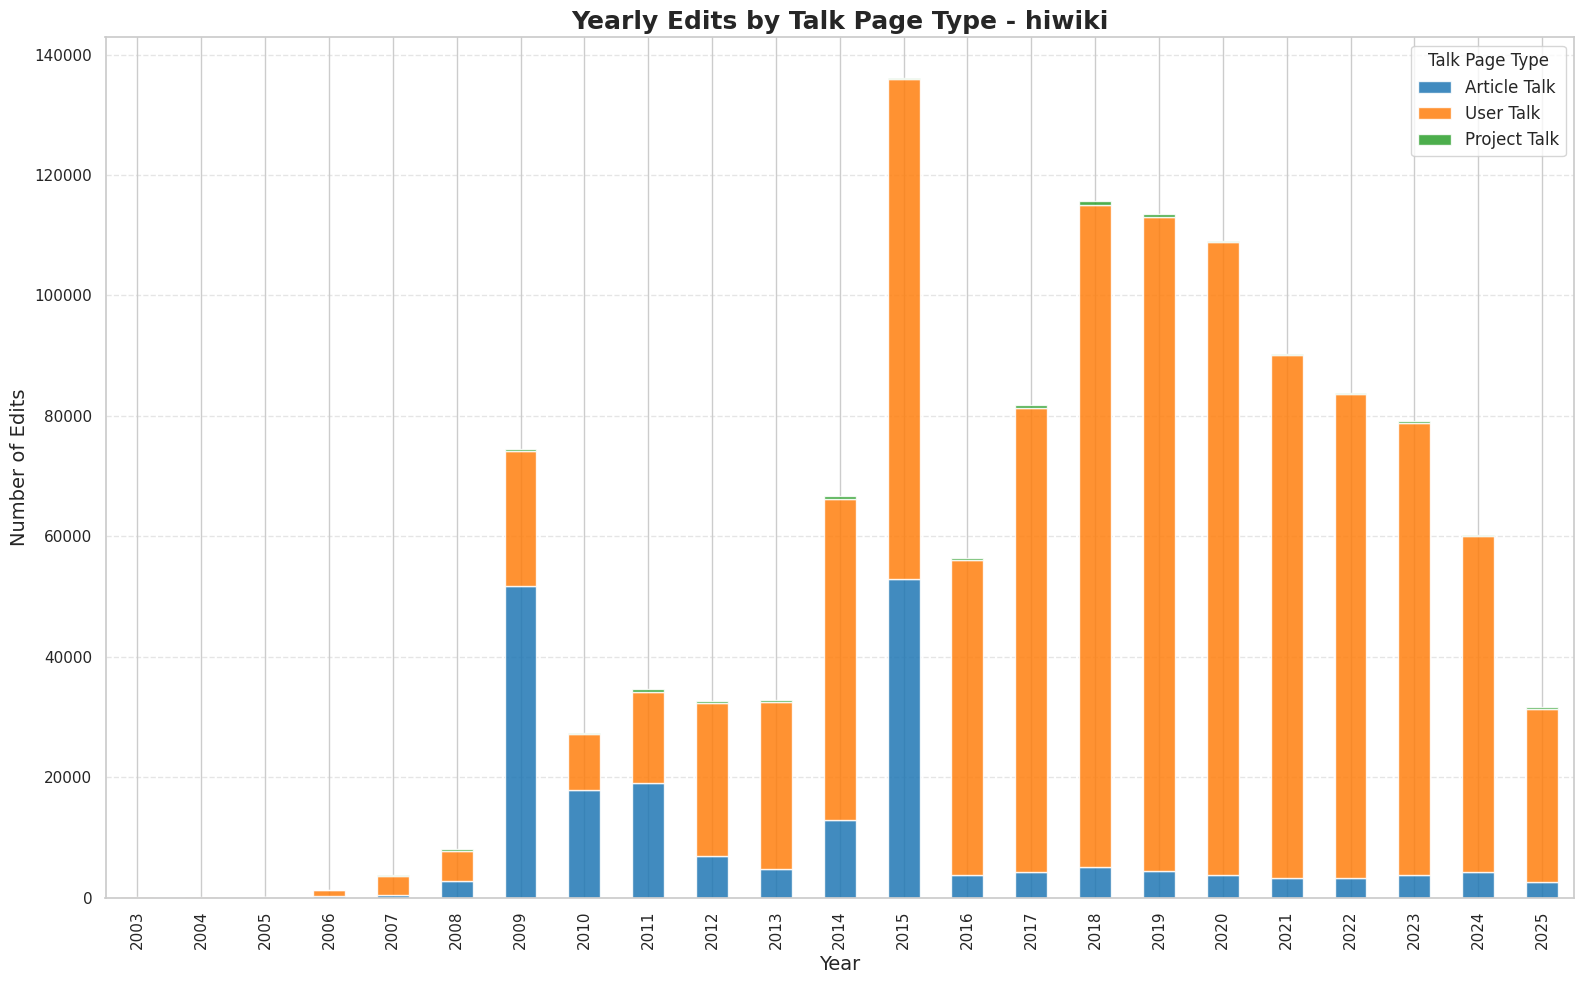

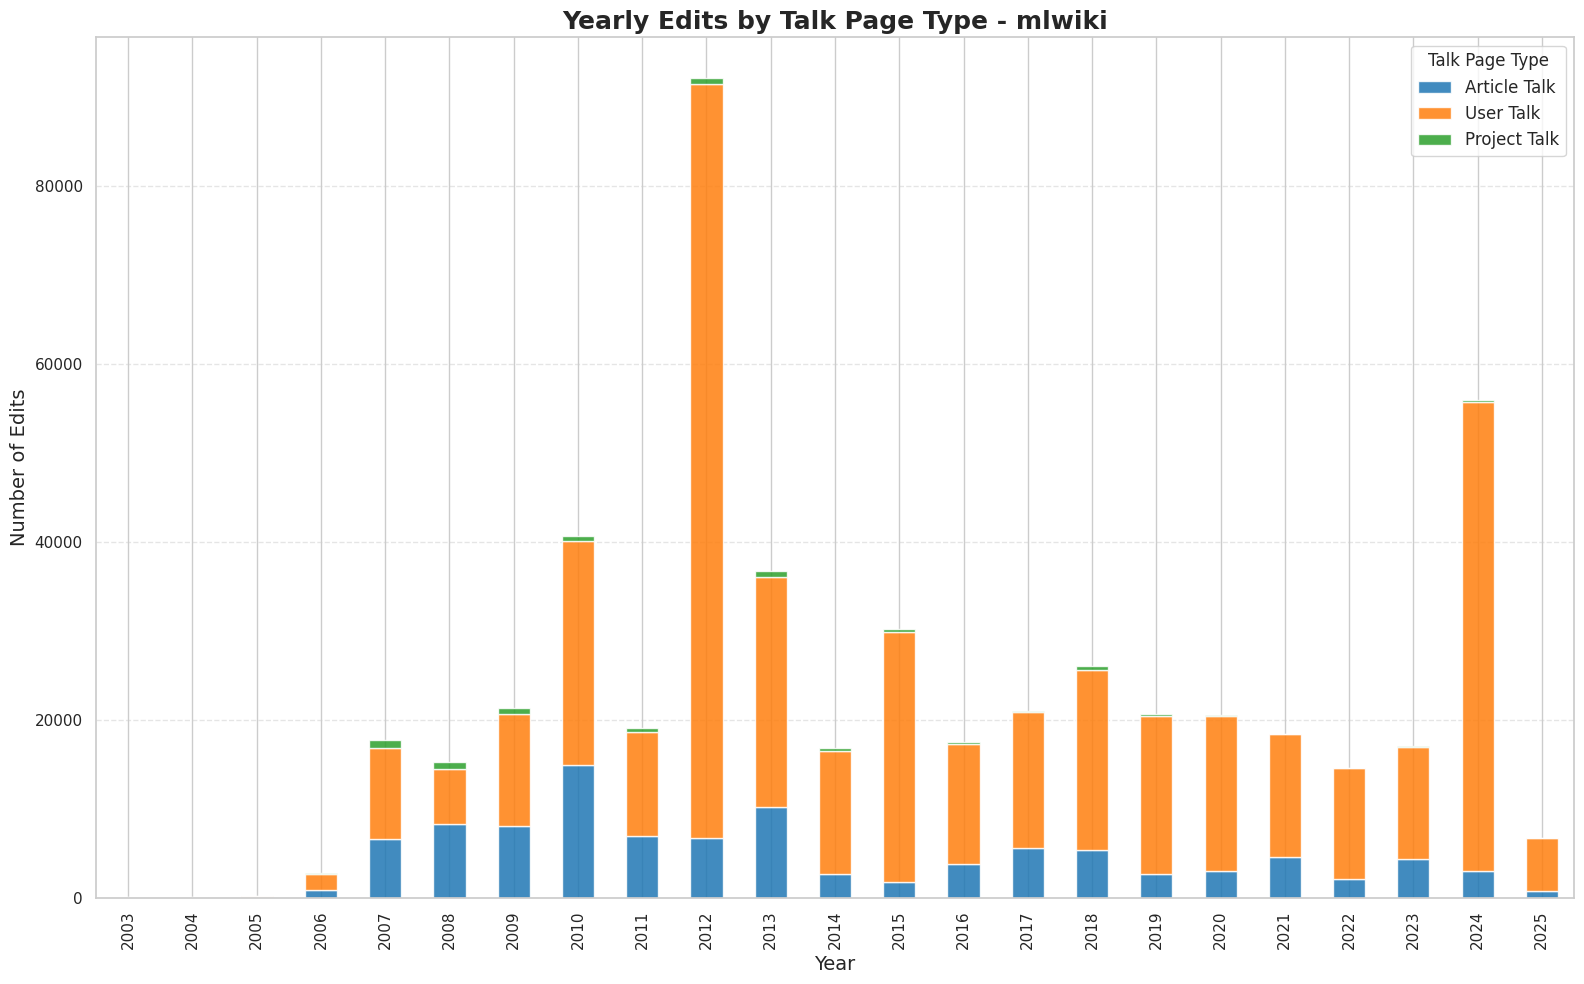

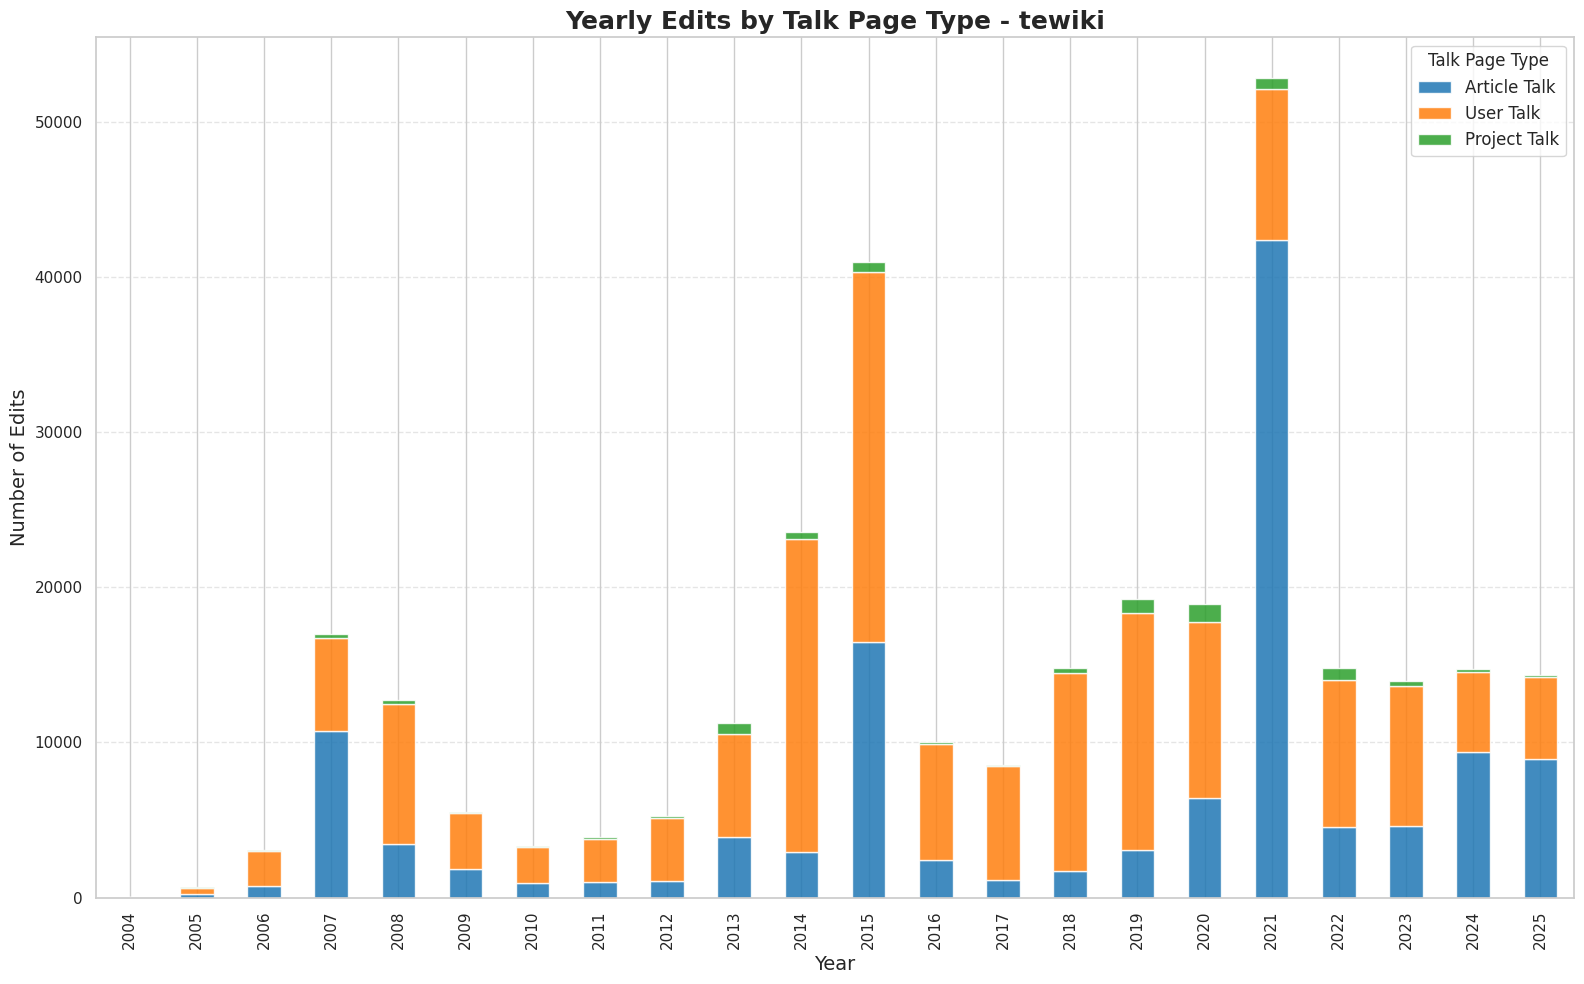

In [37]:
for wiki in combined_df["wiki"].unique():
    temp_df = combined_df[combined_df["wiki"] == wiki].copy()
    plot_yearly_edits(temp_df, wiki)

<h3>number of pages that were never edited after creation</h3>

In [67]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/number_of_pages_that_were_never_edited_after_creation.sql"

query = requests.get(query_url).text

In [68]:
def run_page_edit_query(wikis, query):
    results = []
    for wiki in wikis:
        data = connect_and_query(wiki, query)
        count = data[0][0] if data else 0
        results.append({'wiki': wiki, 'no_of_unedited_pages': count})
    return pd.DataFrame(results)


In [69]:
df_unedited = run_page_edit_query(wikis, query)


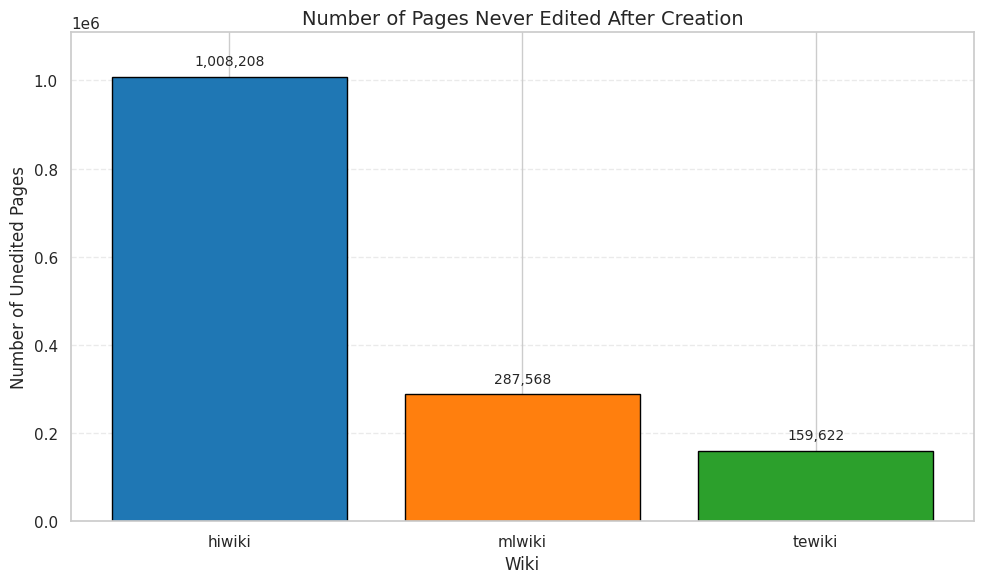

In [86]:

df_unedited['no_of_unedited_pages'] = df_unedited['no_of_unedited_pages'].astype(int)


plt.figure(figsize=(10, 6))

# Plot the bar chart
bars = plt.bar(
    df_unedited['wiki'], 
    df_unedited['no_of_unedited_pages'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
    edgecolor='black'
)

# Titles and labels
plt.title('Number of Pages Never Edited After Creation', fontsize=14)
plt.xlabel('Wiki', fontsize=12)
plt.ylabel('Number of Unedited Pages', fontsize=12)

# Set y-axis limits explicitly
plt.ylim(0, df_unedited['no_of_unedited_pages'].max() * 1.1)

# Show values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 20000, f'{height:,}', 
             ha='center', va='bottom', fontsize=10)

# Final plot tweaks
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()